In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import PIL
from random import randrange
from tensorflow import keras
from tensorflow.keras import layers, losses, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import pathlib
from tensorflow.keras import models

In [8]:
# latent_dim = 64 

# class Autoencoder(Model):
#   def __init__(self, latent_dim):
#     super(Autoencoder, self).__init__()
#     self.latent_dim = latent_dim   
#     self.encoder = tf.keras.Sequential([
#       layers.Flatten(),
#       layers.Dense(latent_dim, activation='relu'),
#     ])
#     self.decoder = tf.keras.Sequential([
#       layers.Dense(784, activation='sigmoid'),
#       layers.Reshape((28, 28))
#     ])

#   def call(self, x):
#     encoded = self.encoder(x)
#     decoded = self.decoder(encoded)
#     return decoded

# autoencoder = Autoencoder(latent_dim)

In [114]:

# class Denoise(Model):
#   def __init__(self):
#     super(Denoise, self).__init__()
#     self.encoder = tf.keras.Sequential([
#       layers.InputLayer(input_shape=(360, 640, 3)),
#       layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
#       layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

#     self.decoder = tf.keras.Sequential([
#       layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
#       layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
#       layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

#   def call(self, x):
#     encoded = self.encoder(x)
#     decoded = self.decoder(encoded)
#     return decoded

# autoencoder = Denoise()

In [12]:
img_height = 180
img_width = 320

class Autoencoder(Model):
  def __init__(self,img_height,img_width):
    super(Autoencoder, self).__init__()
    self.img_height = img_height
    self.img_width = img_width   
    self.encoder = tf.keras.Sequential([
        # layers.experimental.preprocessing.Resizing(180,320),
        layers.Conv2D(32, 8, padding='same', activation='relu'),
        # layers.MaxPooling2D((2,2)),
        layers.Conv2D(32, 8, padding='same', activation='relu'),
        # layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, 8, padding='same', activation='relu'),
        # layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, 8, padding='same', activation='relu'),
        # layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, 8, padding='same', activation='relu')
        # layers.MaxPooling2D((2,2))
    ])
    self.decoder = tf.keras.Sequential([
        # layers.UpSampling2D((2,2)),
        layers.Conv2DTranspose(64, 8, padding='same', activation='relu'),
        # layers.UpSampling2D((2,2)),
        layers.Conv2DTranspose(64, 8, padding='same', activation='relu'),
        # layers.UpSampling2D((2,2)),
        layers.Conv2DTranspose(64, 8, padding='same', activation='relu'),
        # layers.UpSampling2D((2,2)),
        layers.Conv2DTranspose(32, 8, padding='same', activation='relu'),
        # layers.UpSampling2D((2,2)),
        layers.Conv2DTranspose(32, 8, padding='same', activation='relu'),
        layers.Conv2D(1, kernel_size=8, activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded



In [53]:
train_dir = r'C:\Users\ThomasLai\Documents\Uni\SoSe2021\Signalverarbeitung\Project\train\raw'
# batch_size = 5
batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # validation_split = 0.9,
    validation_split = 0.8,
    fill_mode = 'constant'
    
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='input'
    # class_mode="categorical"
)
n_classes = len(train_generator.class_indices)
train_generator.class_indices

Found 699 images belonging to 4 classes.


{'DL1': 0, 'DL2': 1, 'DL3': 2, 'DL_BG': 3}

In [ ]:
autoencoder = Autoencoder(img_height,img_width)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [54]:
autoencoder.fit(train_generator,
    epochs=5,
    shuffle=True,
    verbose=1)

Epoch 1/5
140/140 [==============================] - 141s 999ms/step - loss: 0.0349
Epoch 2/5
140/140 [==============================] - 139s 994ms/step - loss: 0.0205
Epoch 3/5
140/140 [==============================] - 141s 1s/step - loss: 0.0159
Epoch 4/5
140/140 [==============================] - 140s 1s/step - loss: 0.0166
Epoch 5/5
140/140 [==============================] - 140s 999ms/step - loss: 0.0250


In [55]:
# autoencoder.predict()
x = np.array(train_generator.next())

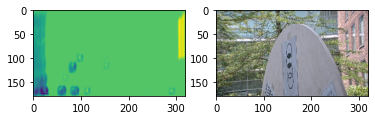

In [56]:
import matplotlib.pyplot as plt
i=1
y_pred = autoencoder.predict(x[0])
plt.subplot(1,2,1)
plt.imshow(y_pred[i])
plt.subplot(1,2,2)
plt.imshow(x[0][i])

In [46]:
conv_base = autoencoder.encoder
model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height,img_width,3)),
    conv_base,
    layers.GlobalMaxPooling2D(name='gap'),
    layers.Dropout(rate=0.2,name='dropout'),
    layers.Dense(n_classes,activation='softmax',name='fc_out')
])
conv_base.trainable = False

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 320, 3)       0         
_________________________________________________________________
sequential_6 (Sequential)    (None, None, None, 64)    727296    
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
fc_out (Dense)               (None, 4)                 260       
Total params: 727,556
Trainable params: 260
Non-trainable params: 727,296
_________________________________________________________________


In [41]:
train_dir = r'C:\Users\ThomasLai\Documents\Uni\SoSe2021\Signalverarbeitung\Project\train\raw'
test_dir = r'C:\Users\ThomasLai\Documents\Uni\SoSe2021\Signalverarbeitung\Project\test\raw'

train_datagen_finetune = ImageDataGenerator(
    rescale=1./255,
    fill_mode = 'constant',
    validation_split=0.3
)
train_generator_finetune = train_datagen_finetune.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(img_height, img_width),
    batch_size=20,
    class_mode="categorical"
)

test_generator_finetune = train_datagen_finetune.flow_from_directory(
    test_dir,
    subset='validation',
    target_size=(img_height, img_width),
    batch_size=20,
    class_mode="categorical"
)

Found 2089 images belonging to 4 classes.
Found 2975 images belonging to 4 classes.


In [47]:
model.fit(train_generator_finetune,
    epochs=10,
    shuffle=True,
    validation_data=test_generator_finetune,
    )

Epoch 1/10
105/105 [==============================] - 57s 540ms/step - loss: 1.3842 - accuracy: 0.2792 - val_loss: 1.3621 - val_accuracy: 0.3166
Epoch 2/10
105/105 [==============================] - 43s 415ms/step - loss: 1.3655 - accuracy: 0.2784 - val_loss: 1.3492 - val_accuracy: 0.3166
Epoch 3/10
105/105 [==============================] - ETA: 0s - loss: 1.3582 - accuracy: 0.2881

KeyboardInterrupt: 